In [1]:
import pandas as pd
from os import path
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
cd '/scratch/users/shrestp/mover/EPIC_EMR/EPIC_EMR/EMR/'

/scratch/users/shrestp/mover/EPIC_EMR/EPIC_EMR/EMR


In [3]:
ls

patient_coding.csv*                 patient_procedure events.csv*
patient_history.csv*                patient_visit.csv*
patient_information.csv*            pressor_patient_meds.csv
patient_labs.csv*                   pressors_09-01.csv
patient_lda.csv*                    pressors_final.csv
patient_medications.csv*            pressors_map_filtered.csv
patient_post_op_complications.csv*


In [4]:
# load map and meds dataFrames and drop duplicates
filepath = '/scratch/users/shrestp/mover/EPIC_flowsheets_cleaned_filtered/MAP.csv'
df_map = pd.read_csv(filepath, index_col=0)
df_map = df_map.drop_duplicates()

# original 
#filepath = '/scratch/users/shrestp/mover/EPIC_EMR/EPIC_EMR/EMR/pressor_patient_meds.csv'
#df_meds = pd.read_csv(filepath, index_col=0)
#df_meds = df_meds.drop_duplicates()

# with demographic data
filepath = '/scratch/users/shrestp/mover/EPIC_EMR/EPIC_EMR/EMR/pressors_09-01.csv'
df_meds = pd.read_csv(filepath, index_col=0)
df_meds = df_meds.drop_duplicates()

In [20]:
# filter medications with inclusion criteria
pattern = r'infusion|IJ|injection|IV'
df_meds = df_meds[df_meds['MEDICATION_NM'].str.contains(pattern, case=False, na=False)]

pattern = r'(?i)(lidocaine|nebu|.*-epinephrine|vasopressin infusion \(anesthesia\))'
df_meds = df_meds[~df_meds['MEDICATION_NM'].str.contains(pattern)]

# drop any medications NAN in the dosage column
df_meds = df_meds.dropna(subset=['ADMIN_SIG'])

/tmp/ipykernel_26502/4065886100.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_meds = df_meds[~df_meds['MEDICATION_NM'].str.contains(pattern)]


### Merging Medications and MAP dataFrame

In [2]:
# keep only the MRNs that appear in both map and med dataFrames
map_MRNs = set(df_map['MRN'])
viable_mrns = list(set(df_map['MRN']).intersection(set(df_meds['MRN'])))
df_map = df_map[df_map['MRN'].isin(viable_mrns)]
df_meds = df_meds[df_meds['MRN'].isin(viable_mrns)]

NameError: name 'df_map' is not defined

In [22]:
df_map

,LOG_ID,MRN,FLO_NAME,FLO_DISPLAY_NAME,RECORD_TYPE,RECORDED_TIME,MEAS_VALUE,UNITS
Unnamed: 0,,,,,,,,
5,d586108388315523,4c482e1b3ab4127a,Vital Signs,MAP (mmHg),POST-OP,2019-10-18 00:00:00,77.0,NaN
159,c0723288e0b0ccc2,5111fb0df8f7deb6,Vital Signs,MAP (mmHg),POST-OP,2019-10-24 00:00:00,64.0,NaN
169,eee273c183272149,77bb0379da107da0,Vital Signs,MAP (mmHg),POST-OP,2019-01-08 00:00:00,69.0,NaN
273,b1ca87d14632244d,d8632f8584f262ae,Vital Signs,MAP (mmHg),POST-OP,2018-12-21 00:00:00,136.0,NaN
300,ac9149a7d42d5785,d8632f8584f262ae,Vital Signs,MAP (mmHg),POST-OP,2018-12-21 00:00:00,136.0,NaN
...,...,...,...,...,...,...,...,...
56958574,eb401383e5774847,4302fbdfaeb959dd,Blood Administration,MAP (mmHg),POST-OP,2022-03-05 22:05:00,84.0,NaN
56958600,eb401383e5774847,4302fbdfaeb959dd,Vital Signs,MAP (mmHg),POST-OP,2022-03-05 22:15:00,83.0,NaN
56958604,eb401383e5774847,4302fbdfaeb959dd,Vital Signs,MAP (mmHg),POST-OP,2022-03-05 22:20:00,85.0,NaN


In [23]:
df_meds

,ENC_TYPE_C,ENC_TYPE_NM,LOG_ID,MRN,ORDERING_DATE,ORDER_CLASS_NM,MEDICATION_ID,DISPLAY_NAME,MEDICATION_NM,START_DATE,END_DATE,ORDER_STATUS_NM,RECORD_TYPE,MAR_ACTION_NM,MED_ACTION_TIME,ADMIN_SIG,DOSE_UNIT_NM,MED_ROUTE_NM
2443,3,Hospital Encounter,5411281f8483f3ab,3acc8370ebdd55c2,2020-06-05 00:00:00,ePrescribe,15982,DOBUTamine (DOBUTREX) premix infusion 1000 mg ...,DOBUTAMINE IN D5W 4-5 MG/ML-% IV SOLN,2020-06-05 00:00:00,2020-06-06 00:00:00,Discontinued,POST-OP,Rate Verify,2020-06-05 17:00:00,1.0,mcg/kg/min,IntraVENOUS
2444,3,Hospital Encounter,5411281f8483f3ab,3acc8370ebdd55c2,2020-06-05 00:00:00,ePrescribe,15982,DOBUTamine (DOBUTREX) premix infusion 1000 mg ...,DOBUTAMINE IN D5W 4-5 MG/ML-% IV SOLN,2020-06-05 00:00:00,2020-06-06 00:00:00,Discontinued,POST-OP,Rate Verify,2020-06-05 18:00:00,1.0,mcg/kg/min,IntraVENOUS
2445,3,Hospital Encounter,5411281f8483f3ab,3acc8370ebdd55c2,2020-06-05 00:00:00,ePrescribe,15982,DOBUTamine (DOBUTREX) premix infusion 1000 mg ...,DOBUTAMINE IN D5W 4-5 MG/ML-% IV SOLN,2020-06-05 00:00:00,2020-06-06 00:00:00,Discontinued,POST-OP,Rate Verify,2020-06-06 00:00:00,1.0,mcg/kg/min,IntraVENOUS
7246,3,Hospital Encounter,e890e27604f6417a,b4cecefb0cb0ec85,2021-02-08 00:00:00,ePrescribe,15982,DOBUTamine (DOBUTREX) premix infusion 1000 mg ...,DOBUTAMINE IN D5W 4-5 MG/ML-% IV SOLN,2021-02-08 00:00:00,2021-02-12 00:00:00,Discontinued,POST-OP,Rate Verify,2021-02-08 23:00:00,5.0,mcg/kg/min,IntraVENOUS
7247,3,Hospital Encounter,e890e27604f6417a,b4cecefb0cb0ec85,2021-02-08 00:00:00,ePrescribe,15982,DOBUTamine (DOBUTREX) premix infusion 1000 mg ...,DOBUTAMINE IN D5W 4-5 MG/ML-% IV SOLN,2021-02-08 00:00:00,2021-02-12 00:00:00,Discontinued,POST-OP,Rate Verify,2021-02-09 04:00:00,5.0,mcg/kg/min,IntraVENOUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27961239,3,Hospital Encounter,6077411a9e3a9cd0,fa67afa1b9bfd23f,2020-08-10 00:00:00,Inpatient,507985,norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),2020-08-10 00:00:00,2020-08-17 00:00:00,Discontinued,POST-OP,Rate Verify,2020-08-12 18:00:00,1.0,mcg/min,IntraVENOUS
27961240,3,Hospital Encounter,6077411a9e3a9cd0,fa67afa1b9bfd23f,2020-08-10 00:00:00,Inpatient,507985,norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),2020-08-10 00:00:00,2020-08-17 00:00:00,Discontinued,POST-OP,Stopped,2020-08-12 21:00:00,0.0,mcg/min,IntraVENOUS
27961241,3,Hospital Encounter,6077411a9e3a9cd0,fa67afa1b9bfd23f,2020-08-10 00:00:00,Inpatient,507985,norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),2020-08-10 00:00:00,2020-08-17 00:00:00,Discontinued,POST-OP,Rate Verify,2020-08-13 03:00:00,2.0,mcg/min,IntraVENOUS
27961242,3,Hospital Encounter,6077411a9e3a9cd0,fa67afa1b9bfd23f,2020-08-10 00:00:00,Inpatient,507985,norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),2020-08-10 00:00:00,2020-08-17 00:00:00,Discontinued,POST-OP,Rate Change,2020-08-13 16:19:00,2.0,mcg/min,IntraVENOUS


In [1]:
df_map[df_map['LOG_ID'] == 'c0723288e0b0ccc2']

NameError: name 'df_map' is not defined

In [31]:
temp = df_meds[df_meds['LOG_ID'] == 'eb401383e5774847']

In [33]:
temp[temp['ORDER_STATUS_NM'] == 'Completed'].sort_values('MED_ACTION_TIME')

,ENC_TYPE_C,ENC_TYPE_NM,LOG_ID,MRN,ORDERING_DATE,ORDER_CLASS_NM,MEDICATION_ID,DISPLAY_NAME,MEDICATION_NM,START_DATE,END_DATE,ORDER_STATUS_NM,RECORD_TYPE,MAR_ACTION_NM,MED_ACTION_TIME,ADMIN_SIG,DOSE_UNIT_NM,MED_ROUTE_NM
13173078,3,Hospital Encounter,eb401383e5774847,4302fbdfaeb959dd,2022-03-07 00:00:00,Inpatient,128263,EPINEPHrine (ADRENALIN) injection (1 mg/10mL) ...,EPINEPHRINE 1 MG/10ML IJ SOSY,2022-03-07 00:00:00,2022-03-07 00:00:00,Completed,POST-OP,Given by Other,2022-03-07 08:42:00,1.0,mg,IntraVENOUS
13173079,3,Hospital Encounter,eb401383e5774847,4302fbdfaeb959dd,2022-03-07 00:00:00,Inpatient,128263,EPINEPHrine (ADRENALIN) injection (1 mg/10mL) ...,EPINEPHRINE 1 MG/10ML IJ SOSY,2022-03-07 00:00:00,2022-03-07 00:00:00,Completed,POST-OP,Given by Other,2022-03-07 08:54:00,1.0,mg,IntraVENOUS
24931232,3,Hospital Encounter,eb401383e5774847,4302fbdfaeb959dd,2022-03-07 00:00:00,Inpatient,128263,EPINEPHrine (ADRENALIN) injection (1 mg/10mL) ...,EPINEPHRINE 1 MG/10ML IJ SOSY,2022-03-07 00:00:00,2022-03-07 00:00:00,Completed,POST-OP,Given by Other,2022-03-07 09:04:00,1.0,mg,IntraVENOUS
17957740,3,Hospital Encounter,eb401383e5774847,4302fbdfaeb959dd,2022-03-07 00:00:00,Inpatient,114429,vasopressin injection 4 Units,VASOPRESSIN 20 UNIT/ML IV SOLN,2022-03-07 00:00:00,2022-03-07 00:00:00,Completed,POST-OP,Given by Other,2022-03-07 09:40:00,4.0,Units,IntraVENOUS
13173082,3,Hospital Encounter,eb401383e5774847,4302fbdfaeb959dd,2022-03-07 00:00:00,Inpatient,114429,vasopressin injection 2 Units,VASOPRESSIN 20 UNIT/ML IV SOLN,2022-03-07 00:00:00,2022-03-07 00:00:00,Completed,POST-OP,Given by Other,2022-03-07 09:55:00,2.0,Units,IntraVENOUS
24880778,3,Hospital Encounter,eb401383e5774847,4302fbdfaeb959dd,2022-03-07 00:00:00,Normal,128263,EPINEPHrine (ADRENALIN) injection (1 mg/10mL),EPINEPHRINE 1 MG/10ML IJ SOSY,2022-03-07 00:00:00,2022-03-07 00:00:00,Completed,POST-OP,Given,2022-03-07 12:06:30,1.0,mg,IntraVENOUS
24990044,3,Hospital Encounter,eb401383e5774847,4302fbdfaeb959dd,2022-03-07 00:00:00,Normal,128263,EPINEPHrine (ADRENALIN) injection (1 mg/10mL),EPINEPHRINE 1 MG/10ML IJ SOSY,2022-03-07 00:00:00,2022-03-07 00:00:00,Completed,POST-OP,Given,2022-03-07 12:09:00,1.0,mg,IntraVENOUS


In [37]:
df_map['MRN'].nunique()

1691

In [38]:
df_meds['MRN'].nunique()

1691

In [39]:
# merge map and med dataFrames on time
merged_df = pd.merge(df_map, df_meds, left_on=['MRN', 'RECORDED_TIME'], right_on=['MRN', 'MED_ACTION_TIME'],
                     how='inner', suffixes=('_map', '_meds'))
merged_df = merged_df.drop_duplicates()

In [40]:
merged_df['MRN'].nunique()

951

In [41]:
# only keep MRNs with more than 10 measurements
mrn_counts = merged_df['MRN'].value_counts(normalize=False)
merged_df = merged_df.loc[merged_df['MRN'].isin(mrn_counts[mrn_counts > 10].index), :]

In [42]:
merged_df['MRN'].nunique()

624

In [71]:
merged_df_small = merged_df[['MRN', 'MED_ACTION_TIME', 'MAR_ACTION_NM', 'ADMIN_SIG', 'DOSE_UNIT_NM', 'MEDICATION_ID', 'MEDICATION_NM', 'DISPLAY_NAME','RECORDED_TIME', 'MEAS_VALUE',]]

In [73]:
merged_df_small.drop_duplicates()

,MRN,MED_ACTION_TIME,MAR_ACTION_NM,ADMIN_SIG,DOSE_UNIT_NM,MEDICATION_ID,MEDICATION_NM,DISPLAY_NAME,RECORDED_TIME,MEAS_VALUE
0,d8632f8584f262ae,2018-12-21 00:00:00,Rate Verify,0.04,Units/min,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...,2018-12-21 00:00:00,136.0
1,d8632f8584f262ae,2018-12-21 00:00:00,Rate Verify,0.50,mcg/kg/min,455306,DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI),DOBUTamine (DOBUTREX) 500 mg in sodium chlorid...,2018-12-21 00:00:00,136.0
18,d8632f8584f262ae,2018-12-21 01:00:00,Rate Verify,0.50,mcg/kg/min,455306,DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI),DOBUTamine (DOBUTREX) 500 mg in sodium chlorid...,2018-12-21 01:00:00,106.0
20,d8632f8584f262ae,2018-12-21 01:00:00,Rate Verify,0.04,Units/min,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...,2018-12-21 01:00:00,106.0
36,d8632f8584f262ae,2018-12-21 02:00:00,Rate Verify,0.50,mcg/kg/min,455306,DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI),DOBUTamine (DOBUTREX) 500 mg in sodium chlorid...,2018-12-21 02:00:00,91.0
...,...,...,...,...,...,...,...,...,...,...
883434,1e95f053a3a83aaa,2022-09-28 23:00:00,Rate Verify,0.03,Units/min,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...,2022-09-28 23:00:00,67.0
883457,fca5e82869562497,2022-09-10 13:15:00,Rate Change,57.00,mcg/min,455636,NOREPINEPHRINE 16 MG/250 ML NS INFUSION (NEURO...,norepinephrine (LEVOPHED) 16 mg in sodium chlo...,2022-09-10 13:15:00,92.0
883463,fca5e82869562497,2022-09-10 13:30:00,Rate Change,56.00,mcg/min,455636,NOREPINEPHRINE 16 MG/250 ML NS INFUSION (NEURO...,norepinephrine (LEVOPHED) 16 mg in sodium chlo...,2022-09-10 13:30:00,85.0
883469,ff2825c4d035db2a,2022-11-09 21:00:00,Rate Verify,8.00,mcg/min,121925,NOREPINEPHRINE-SODIUM CHLORIDE 8-0.9 MG/250ML-...,norepinephrine 8 mg in sodium chloride 0.9% 25...,2022-11-09 21:00:00,69.0


In [72]:
merged_df_small.sort_values('MED_ACTION_TIME')

,MRN,MED_ACTION_TIME,MAR_ACTION_NM,ADMIN_SIG,DOSE_UNIT_NM,MEDICATION_ID,MEDICATION_NM,DISPLAY_NAME,RECORDED_TIME,MEAS_VALUE
0,d8632f8584f262ae,2018-12-21 00:00:00,Rate Verify,0.04,Units/min,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...,2018-12-21 00:00:00,136.0
17,d8632f8584f262ae,2018-12-21 00:00:00,Rate Verify,0.50,mcg/kg/min,455306,DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI),DOBUTamine (DOBUTREX) 500 mg in sodium chlorid...,2018-12-21 00:00:00,136.0
16,d8632f8584f262ae,2018-12-21 00:00:00,Rate Verify,0.50,mcg/kg/min,455306,DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI),DOBUTamine (DOBUTREX) 500 mg in sodium chlorid...,2018-12-21 00:00:00,136.0
15,d8632f8584f262ae,2018-12-21 00:00:00,Rate Verify,0.04,Units/min,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...,2018-12-21 00:00:00,136.0
14,d8632f8584f262ae,2018-12-21 00:00:00,Rate Verify,0.04,Units/min,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...,2018-12-21 00:00:00,136.0
...,...,...,...,...,...,...,...,...,...,...
593690,089844505389b86d,2023-05-03 18:00:00,Rate Change,5.00,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2023-05-03 18:00:00,58.0
593689,089844505389b86d,2023-05-03 18:00:00,Rate Change,5.00,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2023-05-03 18:00:00,58.0
593688,089844505389b86d,2023-05-03 18:00:00,Rate Change,5.00,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2023-05-03 18:00:00,58.0
593686,089844505389b86d,2023-05-03 18:00:00,Rate Change,5.00,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2023-05-03 18:00:00,58.0


In [61]:
merged_df_small[merged_df_small['MAR_ACTION_NM'] == 'Canceled Entry']

,MRN,MED_ACTION_TIME,MAR_ACTION_NM,ADMIN_SIG,DOSE_UNIT_NM,MEDICATION_ID,MEDICATION_NM,DISPLAY_NAME,RECORDED_TIME,MEAS_VALUE
3812,dd69b81e616947b0,2019-09-13 01:00:00,Canceled Entry,4.0,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2019-09-13 01:00:00,86.0
3813,dd69b81e616947b0,2019-09-13 01:00:00,Canceled Entry,4.0,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2019-09-13 01:00:00,86.0
3814,dd69b81e616947b0,2019-09-13 01:00:00,Canceled Entry,4.0,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2019-09-13 01:00:00,86.0
3815,dd69b81e616947b0,2019-09-13 01:00:00,Canceled Entry,4.0,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2019-09-13 01:00:00,86.0
3816,dd69b81e616947b0,2019-09-13 01:00:00,Canceled Entry,4.0,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2019-09-13 01:00:00,86.0
...,...,...,...,...,...,...,...,...,...,...
857627,076b085c5c79cdf7,2022-07-03 02:00:00,Canceled Entry,NaN,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2022-07-03 02:00:00,74.0
857628,076b085c5c79cdf7,2022-07-03 02:00:00,Canceled Entry,NaN,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2022-07-03 02:00:00,74.0
857629,076b085c5c79cdf7,2022-07-03 02:00:00,Canceled Entry,NaN,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2022-07-03 02:00:00,74.0
857630,076b085c5c79cdf7,2022-07-03 02:00:00,Canceled Entry,NaN,mcg/min,507985,NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI),norepinephrine (LEVOPHED) 4 mg in 250 mL NS (L...,2022-07-03 02:00:00,74.0


In [62]:
merged_df_small[merged_df_small['MAR_ACTION_NM'] == 'Canceled Entry']['ADMIN_SIG'].value_counts()

ADMIN_SIG
26.0    160
5.0     117
0.0      86
30.0     80
3.0      77
4.0      13
11.0      9
10.0      4
15.0      2
Name: count, dtype: int64

In [45]:
single_occurrence_mrns = mrn_counts[mrn_counts == 1]
single_occurrence_mrns.count()

0

In [20]:
merged_df['START_DATE'] = pd.to_datetime(merged_df['START_DATE'])
merged_df['END_DATE'] = pd.to_datetime(merged_df['END_DATE'])
merged_df['STAY_LENGTH'] = merged_df['END_DATE'] - merged_df['START_DATE']


merged_df['STAY_LENGTH'] = merged_df['STAY_LENGTH'].dt.days # convert to days

In [21]:
merged_df['STAY_LENGTH'].unique()

array([ 6,  5, 16,  3,  4,  2,  1,  0,  8,  7, 20,  9, 11, 18, 10, 13, 15,
       12, 14, 22, 19, 46, 50, 17, 35, 24, 25, 21, 32, 29, 26, 42, 31, 36,
       28, 37, 41, 23])

In [23]:
merged_df

,LOG_ID_map,MRN,FLO_NAME,FLO_DISPLAY_NAME,RECORD_TYPE_map,RECORDED_TIME,MEAS_VALUE,UNITS,ENC_TYPE_NM,LOG_ID_meds,...,ORDER_STATUS_NM,RECORD_TYPE_meds,MAR_ACTION_NM,MED_ACTION_TIME,ADMIN_SIG,DOSE_UNIT_NM,MED_ROUTE_NM,ICU_ADMIN_FLAG,SURGERY_DATE,STAY_LENGTH
0,b1ca87d14632244d,d8632f8584f262ae,Vital Signs,MAP (mmHg),POST-OP,2018-12-21 00:00:00,136.0,NaN,Hospital Encounter,ac9149a7d42d5785,...,Discontinued,POST-OP,Rate Verify,2018-12-21 00:00:00,0.04,Units/min,IntraVENOUS,Yes,2018-12-08,6
1,b1ca87d14632244d,d8632f8584f262ae,Vital Signs,MAP (mmHg),POST-OP,2018-12-21 00:00:00,136.0,NaN,Hospital Encounter,b1ca87d14632244d,...,Discontinued,POST-OP,Rate Verify,2018-12-21 00:00:00,0.50,mcg/kg/min,IntraVENOUS,Yes,2018-12-08,5
2,b1ca87d14632244d,d8632f8584f262ae,Vital Signs,MAP (mmHg),POST-OP,2018-12-21 00:00:00,136.0,NaN,Hospital Encounter,1495917f2226d839,...,Discontinued,POST-OP,Rate Verify,2018-12-21 00:00:00,0.04,Units/min,IntraVENOUS,Yes,2018-12-11,6
3,b1ca87d14632244d,d8632f8584f262ae,Vital Signs,MAP (mmHg),POST-OP,2018-12-21 00:00:00,136.0,NaN,Hospital Encounter,b1ca87d14632244d,...,Discontinued,POST-OP,Rate Verify,2018-12-21 00:00:00,0.04,Units/min,IntraVENOUS,Yes,2018-12-08,6
4,b1ca87d14632244d,d8632f8584f262ae,Vital Signs,MAP (mmHg),POST-OP,2018-12-21 00:00:00,136.0,NaN,Hospital Encounter,ac9149a7d42d5785,...,Discontinued,POST-OP,Rate Verify,2018-12-21 00:00:00,0.50,mcg/kg/min,IntraVENOUS,Yes,2018-12-08,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354221,27259134b593d9bd,ff2825c4d035db2a,Dialysis Vitals and Treatment,MAP (mmHg),POST-OP,2022-11-09 21:00:00,69.0,NaN,Hospital Encounter,27259134b593d9bd,...,Discontinued,POST-OP,Rate Verify,2022-11-09 21:00:00,8.00,mcg/min,IntraVENOUS,Yes,2022-10-30,5
354222,01daf9bab4ab106a,0643e16f5e17692d,Drip Titration,MAP (mmHg),POST-OP,2022-06-11 23:41:00,69.0,NaN,Hospital Encounter,7cef1c70612757e1,...,Discontinued,POST-OP,Rate Change,2022-06-11 23:41:00,9.00,mcg/min,IntraVENOUS,Yes,2022-06-03,13
354223,01daf9bab4ab106a,0643e16f5e17692d,Drip Titration,MAP (mmHg),POST-OP,2022-06-11 23:41:00,69.0,NaN,Hospital Encounter,d94750a541c1a2fa,...,Discontinued,NaN,Rate Change,2022-06-11 23:41:00,9.00,mcg/min,IntraVENOUS,Yes,2022-05-31,13
354224,7cef1c70612757e1,0643e16f5e17692d,Drip Titration,MAP (mmHg),POST-OP,2022-06-11 23:41:00,69.0,NaN,Hospital Encounter,7cef1c70612757e1,...,Discontinued,POST-OP,Rate Change,2022-06-11 23:41:00,9.00,mcg/min,IntraVENOUS,Yes,2022-06-03,13


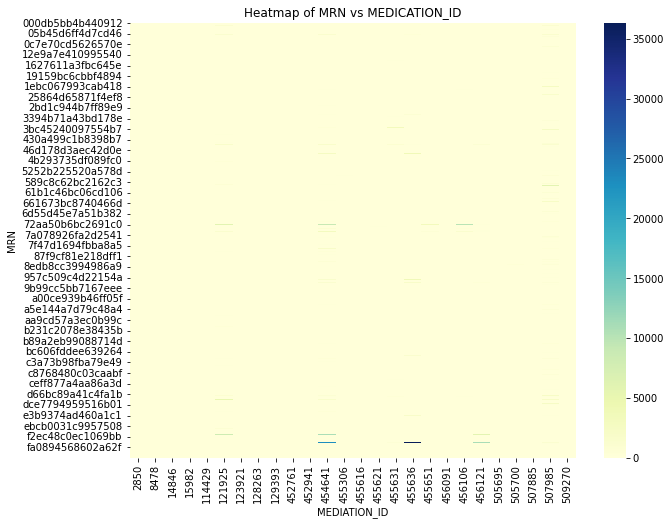

In [24]:
# Pivot the DataFrame
heatmap_data = merged_df.pivot_table(index='MRN', columns='MEDICATION_ID', aggfunc='size', fill_value=0)

plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)

plt.xlabel('MEDIATION_ID')
plt.ylabel('MRN')
plt.title('Heatmap of MRN vs MEDICATION_ID')

plt.show()

In [25]:
merged_df['MRN'].nunique()

697

In [26]:
merged_df = merged_df.drop_duplicates()

In [27]:
merged_df.columns

Index(['LOG_ID_map', 'MRN', 'FLO_NAME', 'FLO_DISPLAY_NAME', 'RECORD_TYPE_map',
       'RECORDED_TIME', 'MEAS_VALUE', 'UNITS', 'ENC_TYPE_NM', 'LOG_ID_meds',
       'ORDERING_DATE', 'ORDER_CLASS_NM', 'MEDICATION_ID', 'DISPLAY_NAME',
       'MEDICATION_NM', 'START_DATE', 'END_DATE', 'ORDER_STATUS_NM',
       'RECORD_TYPE_meds', 'MAR_ACTION_NM', 'MED_ACTION_TIME', 'ADMIN_SIG',
       'DOSE_UNIT_NM', 'MED_ROUTE_NM', 'ICU_ADMIN_FLAG', 'SURGERY_DATE',
       'STAY_LENGTH'],
      dtype='object')

In [28]:
merged_df[['MRN', 'MED_ACTION_TIME', 'RECORDED_TIME', 'MEAS_VALUE', 'MEDICATION_ID', 'MEDICATION_NM', 'DISPLAY_NAME']]

,MRN,MED_ACTION_TIME,RECORDED_TIME,MEAS_VALUE,MEDICATION_ID,MEDICATION_NM,DISPLAY_NAME
0,d8632f8584f262ae,2018-12-21 00:00:00,2018-12-21 00:00:00,136.0,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...
1,d8632f8584f262ae,2018-12-21 00:00:00,2018-12-21 00:00:00,136.0,455306,DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI),DOBUTamine (DOBUTREX) 500 mg in sodium chlorid...
2,d8632f8584f262ae,2018-12-21 00:00:00,2018-12-21 00:00:00,136.0,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...
3,d8632f8584f262ae,2018-12-21 00:00:00,2018-12-21 00:00:00,136.0,454641,VASOPRESSIN INFUSION (UCI),vasopressin 20 Units in sodium chloride 0.9 % ...
4,d8632f8584f262ae,2018-12-21 00:00:00,2018-12-21 00:00:00,136.0,455306,DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI),DOBUTamine (DOBUTREX) 500 mg in sodium chlorid...
...,...,...,...,...,...,...,...
354221,ff2825c4d035db2a,2022-11-09 21:00:00,2022-11-09 21:00:00,69.0,121925,NOREPINEPHRINE-SODIUM CHLORIDE 8-0.9 MG/250ML-...,norepinephrine 8 mg in sodium chloride 0.9% 25...
354222,0643e16f5e17692d,2022-06-11 23:41:00,2022-06-11 23:41:00,69.0,455636,NOREPINEPHRINE 16 MG/250 ML NS INFUSION (NEURO...,norepinephrine (LEVOPHED) 16 mg in sodium chlo...
354223,0643e16f5e17692d,2022-06-11 23:41:00,2022-06-11 23:41:00,69.0,455636,NOREPINEPHRINE 16 MG/250 ML NS INFUSION (NEURO...,norepinephrine (LEVOPHED) 16 mg in sodium chlo...
354224,0643e16f5e17692d,2022-06-11 23:41:00,2022-06-11 23:41:00,69.0,455636,NOREPINEPHRINE 16 MG/250 ML NS INFUSION (NEURO...,norepinephrine (LEVOPHED) 16 mg in sodium chlo...


In [29]:
merged_df['MEDICATION_NM'].nunique()

29

In [30]:
merged_df['MEDICATION_ID'].nunique()

26

In [31]:
merged_df[['MEDICATION_ID', 'MEDICATION_NM']].drop_duplicates().sort_values(by='MEDICATION_ID')

,MEDICATION_ID,MEDICATION_NM
171272,2850,EPINEPHrine 1:1000 (1 mg/mL) injection (1 mg/m...
135125,2850,EPINEPHRINE HCL 1 MG/ML IJ SOLN
11208,8478,VASOPRESSIN 20 UNIT/ML IJ SOLN
157892,14846,DOPAMINE IN D5W 3.2-5 MG/ML-% IV SOLN
2370,15982,DOBUTAMINE IN D5W 4-5 MG/ML-% IV SOLN
17354,114429,VASOPRESSIN 20 UNIT/ML IV SOLN
166586,121925,NOREPINEPHRINE-SODIUM CHLORIDE 8-0.9 MG/250ML-...
151519,123921,NOREPINEPHRINE-DEXTROSE 16-5 MG/250ML-% IV SOLN
172087,128263,EPINEPHRINE 1 MG/10ML IJ SOSY
153365,129393,EPINEPHRINE PF 1 MG/10ML IJ SOSY


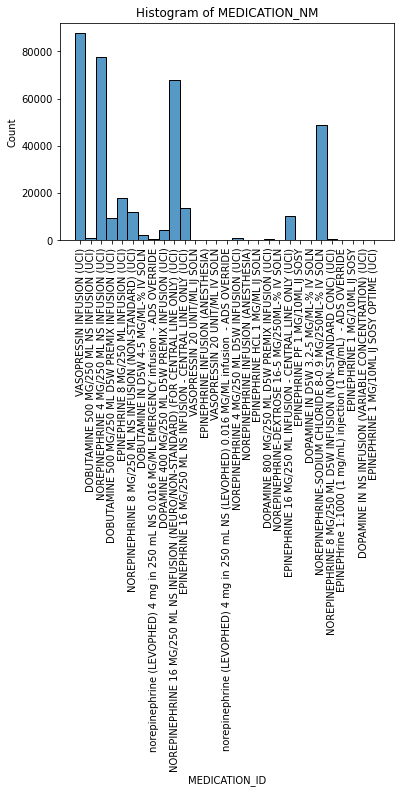

In [32]:
# Plot the histogram with discrete=True to treat 'MEDICATION_ID' as discrete
sns.histplot(merged_df['MEDICATION_NM'], discrete=True)

# Add labels and title
plt.xlabel('MEDICATION_ID')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.title('Histogram of MEDICATION_NM')

# Show the plot
plt.show()

In [33]:
medication_map = merged_df.groupby('MEDICATION_ID')['MEDICATION_NM'].first()

# Replace the 'MEDICATION_NM' values in the original DataFrame
merged_df['MEDICATION_NM'] = merged_df['MEDICATION_ID'].map(medication_map)

In [34]:
merged_df['MEDICATION_NM'].nunique()

26

In [35]:
merged_df['MEDICATION_ID'].nunique()

26

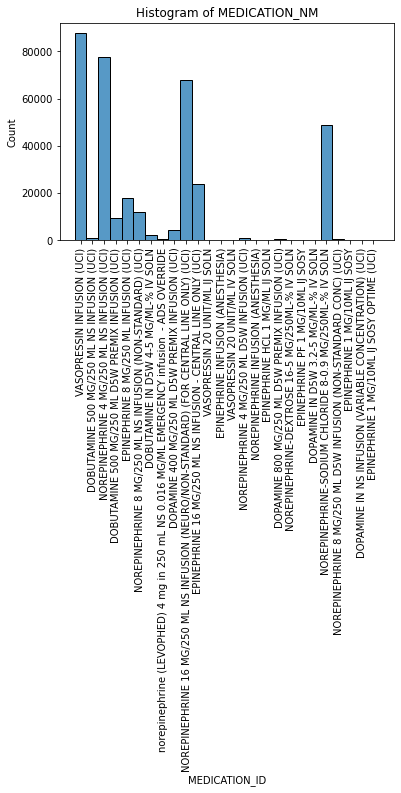

In [36]:
# Plot the histogram with discrete=True to treat 'MEDICATION_ID' as discrete
sns.histplot(merged_df['MEDICATION_NM'], discrete=True)

# Add labels and title
plt.xlabel('MEDICATION_ID')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.title('Histogram of MEDICATION_NM')

# Show the plot
plt.show()

In [37]:
merged_df['MEDICATION_NM'].unique()

array(['VASOPRESSIN INFUSION (UCI)',
       'DOBUTAMINE 500 MG/250 ML NS INFUSION (UCI)',
       'NOREPINEPHRINE 4 MG/250 ML NS INFUSION (UCI)',
       'DOBUTAMINE 500 MG/250 ML D5W PREMIX INFUSION (UCI)',
       'EPINEPHRINE 8 MG/250 ML INFUSION (UCI)',
       'NOREPINEPHRINE 8 MG/250 ML NS INFUSION (NON-STANDARD) (UCI)',
       'DOBUTAMINE IN D5W 4-5 MG/ML-% IV SOLN',
       'norepinephrine (LEVOPHED) 4 mg in 250 mL NS 0.016 MG/ML EMERGENCY infusion  - ADS OVERRIDE',
       'DOPAMINE 400 MG/250 ML D5W PREMIX INFUSION (UCI)',
       'NOREPINEPHRINE 16 MG/250 ML NS INFUSION (NEURO/NON-STANDARD) (FOR CENTRAL LINE ONLY) (UCI)',
       'EPINEPHRINE 16 MG/250 ML NS INFUSION - CENTRAL LINE ONLY (UCI)',
       'VASOPRESSIN 20 UNIT/ML IJ SOLN',
       'EPINEPHRINE INFUSION (ANESTHESIA)',
       'VASOPRESSIN 20 UNIT/ML IV SOLN',
       'NOREPINEPHRINE 4 MG/250 ML D5W INFUSION (UCI)',
       'NOREPINEPHRINE INFUSION (ANESTHESIA)',
       'EPINEPHRINE HCL 1 MG/ML IJ SOLN',
       'DOPAMINE 800 M

In [38]:
merged_df['MEDICATION_ID'].unique()

array([454641, 455306, 507985, 455651, 456106, 455631,  15982, 507885,
       505695, 455636, 456121,   8478, 452941, 114429, 455616, 452761,
         2850, 505700, 123921, 129393,  14846, 121925, 455621, 128263,
       456091, 509270])

In [43]:
random_seed = 42
selected_mrns = df_map['MRN'].sample(n=10, random_state=random_seed)
selected_map = df_map[df_map['MRN'].isin(selected_mrns)]
selected_meds = df_meds[df_meds['MRN'].isin(selected_mrns)]

In [44]:
selected_merged_df = pd.merge(selected_map, selected_meds, left_on=['MRN', 'RECORDED_TIME'], right_on=['MRN', 'MED_ACTION_TIME'],
                     how='inner', suffixes=('_map', '_meds'))

In [45]:
selected_merged_df['MRN'].unique()

array(['ac69242abe6ac8fb', 'fea44bb1010f01ca', '9bae32b18d81e6d5',
       'c6d0861c0f9dc127', 'c04a95ec08335ccd', 'dc7b602f0e2b6dac',
       'f0bef91fc7b65906', '0e5f019e42110e36'], dtype=object)

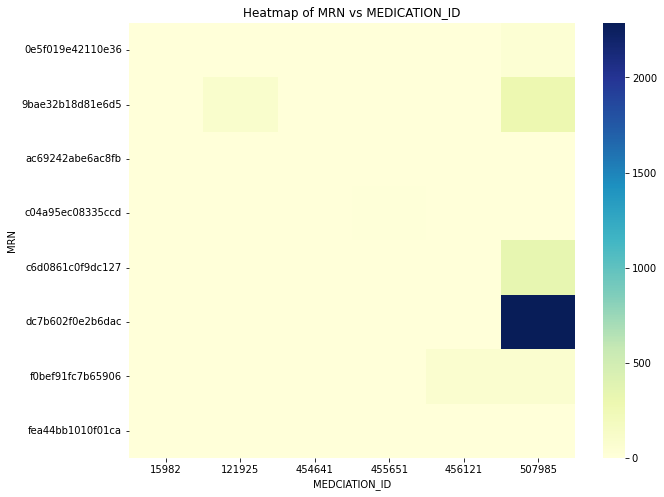

In [46]:
# Assuming df is your DataFrame
# Pivot the DataFrame
heatmap_data = selected_merged_df.pivot_table(index='MRN', columns='MEDICATION_ID', aggfunc='size', fill_value=0)

# Plot the heatmap using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False)

# Add labels and title
plt.xlabel('MEDCIATION_ID')
plt.ylabel('MRN')
plt.title('Heatmap of MRN vs MEDICATION_ID')

# Show the plot
plt.show()

In [47]:
selected_merged_df

,LOG_ID_map,MRN,FLO_NAME,FLO_DISPLAY_NAME,RECORD_TYPE_map,RECORDED_TIME,MEAS_VALUE,UNITS,ENC_TYPE_NM,LOG_ID_meds,...,END_DATE,ORDER_STATUS_NM,RECORD_TYPE_meds,MAR_ACTION_NM,MED_ACTION_TIME,ADMIN_SIG,DOSE_UNIT_NM,MED_ROUTE_NM,ICU_ADMIN_FLAG,SURGERY_DATE
0,f19d578e8f0d79f6,ac69242abe6ac8fb,Vital Signs,MAP (mmHg),POST-OP,2019-10-31 03:45:00,99.0,NaN,Hospital Encounter,f19d578e8f0d79f6,...,2019-11-07 00:00:00,Discontinued,POST-OP,Due,2019-10-31 03:45:00,NaN,mcg/min,IntraVENOUS,Yes,2019-10-30
1,6803d78d3a682e2d,fea44bb1010f01ca,Vital Signs,MAP (mmHg),POST-OP,2020-07-02 09:00:00,102.0,NaN,Hospital Encounter,6803d78d3a682e2d,...,2020-07-02 00:00:00,Discontinued,POST-OP,Rate Verify,2020-07-02 09:00:00,2.5,mcg/kg/min,IntraVENOUS,Yes,2020-06-29
2,824991db1f782e15,9bae32b18d81e6d5,Vital Signs,MAP (mmHg),POST-OP,2022-06-27 06:00:00,81.0,NaN,Hospital Encounter,ad1ce5fc0281f59a,...,2022-06-28 00:00:00,Discontinued,POST-OP,Rate Verify,2022-06-27 06:00:00,2.0,mcg/min,IntraVENOUS,Yes,2022-06-13
3,824991db1f782e15,9bae32b18d81e6d5,Vital Signs,MAP (mmHg),POST-OP,2022-06-27 06:00:00,81.0,NaN,Hospital Encounter,824991db1f782e15,...,2022-06-28 00:00:00,Discontinued,POST-OP,Rate Verify,2022-06-27 06:00:00,2.0,mcg/min,IntraVENOUS,Yes,2022-06-15
4,824991db1f782e15,9bae32b18d81e6d5,Vital Signs,MAP (mmHg),POST-OP,2022-06-27 06:00:00,81.0,NaN,Hospital Encounter,161d0a48cf44fecf,...,2022-06-28 00:00:00,Discontinued,POST-OP,Rate Verify,2022-06-27 06:00:00,2.0,mcg/min,IntraVENOUS,Yes,2022-06-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3221,7eeccc5cea4e4381,c6d0861c0f9dc127,Blood Administration,MAP (mmHg),POST-OP,2022-05-12 15:30:00,82.0,NaN,Hospital Encounter,54b872f881a61de2,...,2022-05-19 00:00:00,Discontinued,POST-OP,Rate Change,2022-05-12 15:30:00,3.0,mcg/min,IntraVENOUS,Yes,2022-04-21
3222,7eeccc5cea4e4381,c6d0861c0f9dc127,Blood Administration,MAP (mmHg),POST-OP,2022-05-12 15:30:00,82.0,NaN,Hospital Encounter,d9e8005c5ef49ca5,...,2022-05-19 00:00:00,Discontinued,POST-OP,Rate Change,2022-05-12 15:30:00,3.0,mcg/min,IntraVENOUS,Yes,2022-05-07
3223,f60405058d5bdd14,c04a95ec08335ccd,Vital Signs,MAP (mmHg),POST-OP,2022-03-25 20:00:00,87.0,NaN,Hospital Encounter,db83d4615dc72111,...,2022-03-26 00:00:00,Discontinued,NaN,Rate Verify,2022-03-25 20:00:00,2.0,mcg/kg/min,IntraVENOUS,Yes,2022-03-23
3224,f60405058d5bdd14,c04a95ec08335ccd,Vital Signs,MAP (mmHg),POST-OP,2022-03-25 22:00:00,82.0,NaN,Hospital Encounter,db83d4615dc72111,...,2022-03-26 00:00:00,Discontinued,NaN,Rate Verify,2022-03-25 22:00:00,2.0,mcg/kg/min,IntraVENOUS,Yes,2022-03-23


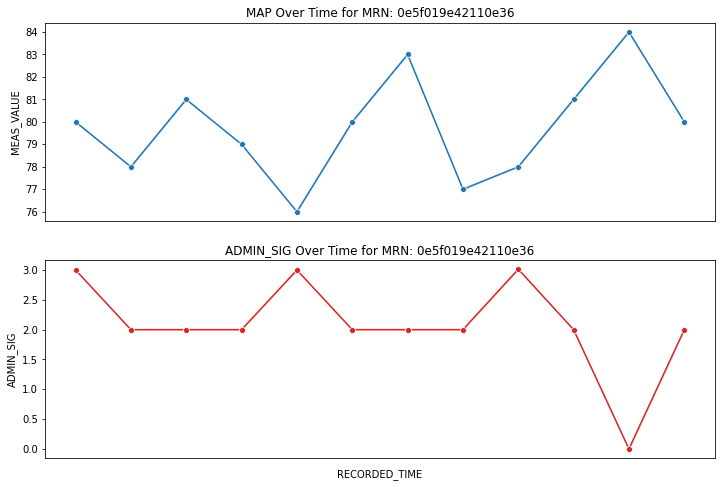

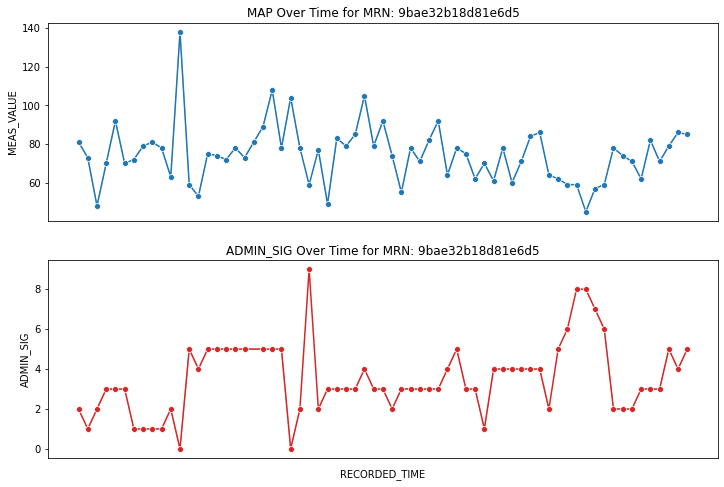

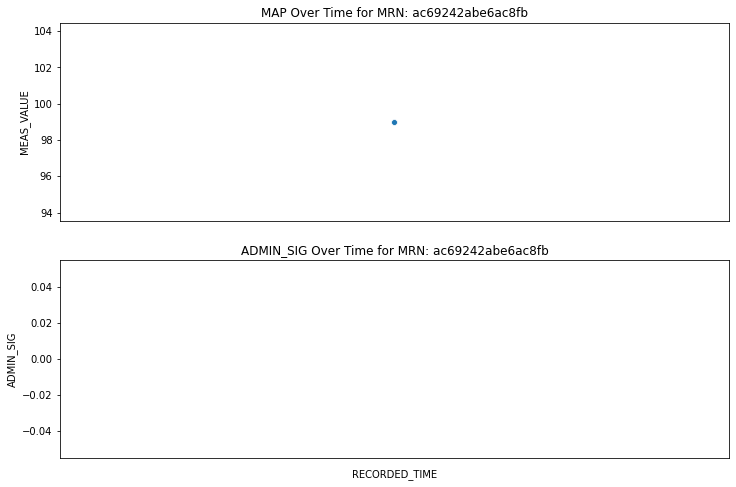

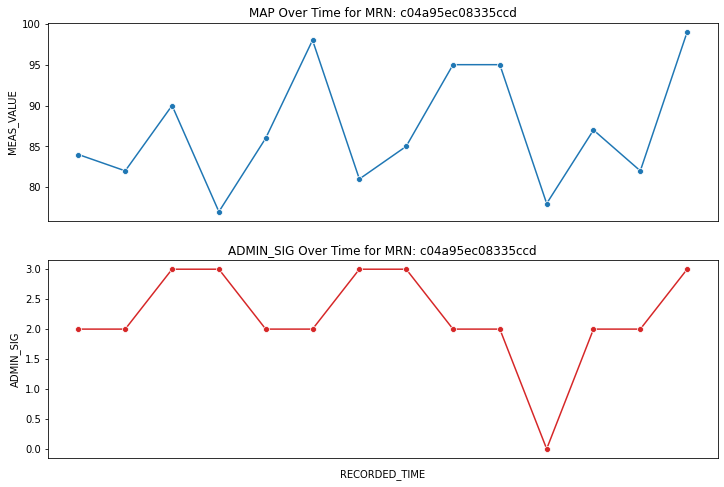

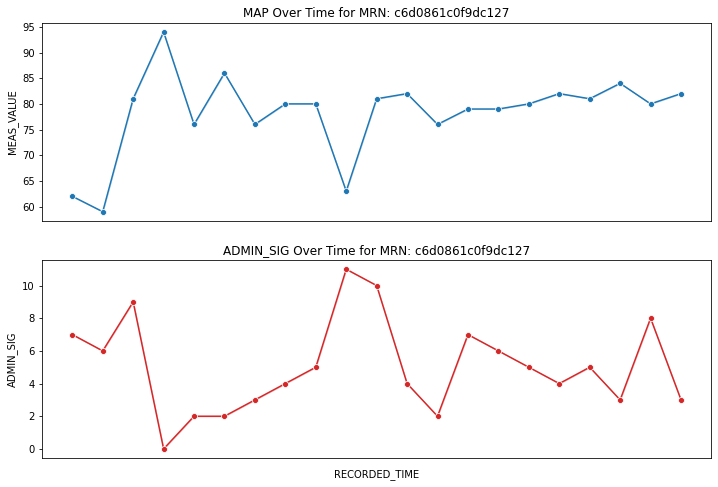

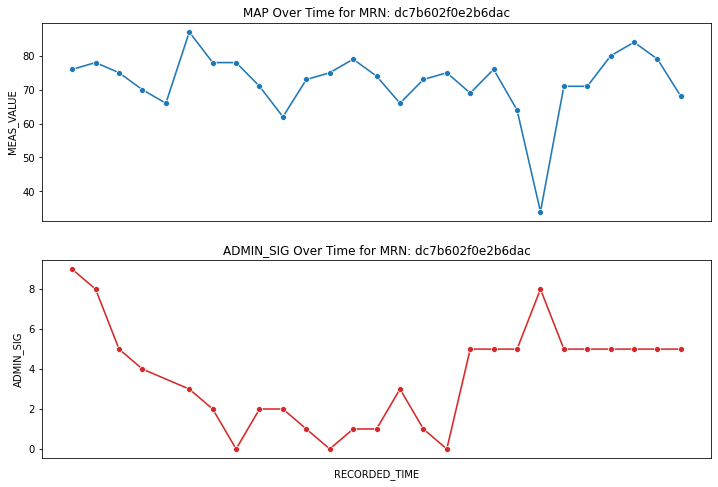

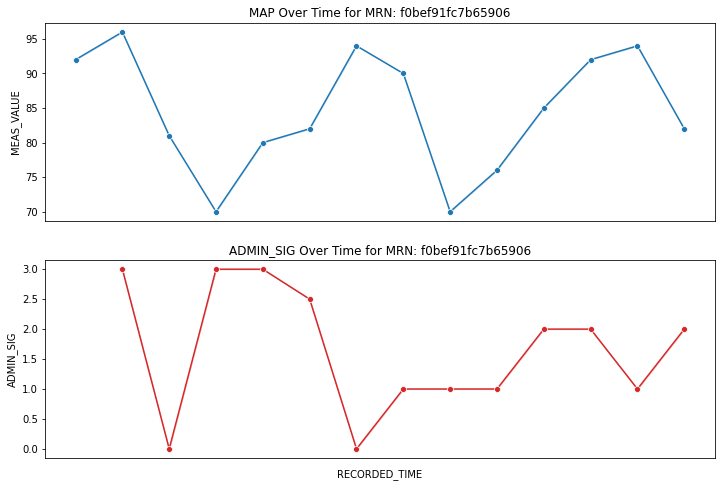

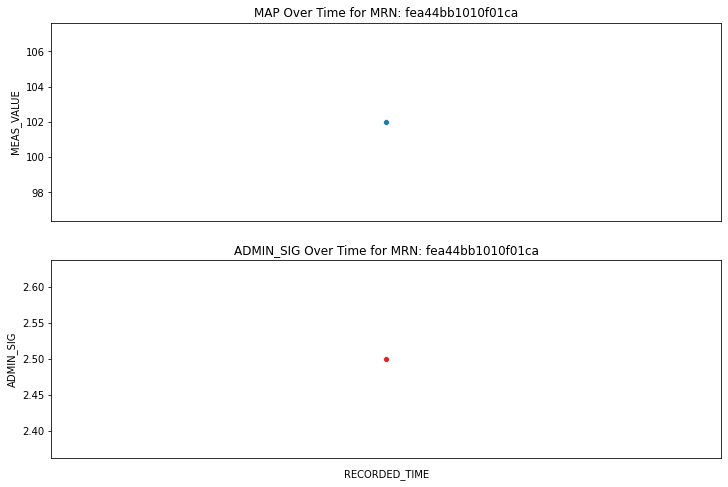

In [50]:
# Filter for the relevant columns
filtered_df = selected_merged_df[['MRN', 'RECORDED_TIME', 'MEAS_VALUE', 'ADMIN_SIG']]

# Loop through each unique MRN (patient)
for mrn, patient_df in filtered_df.groupby('MRN'):
    # Create a figure with 2 subplots (axes)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot the MAP (MEAS_VALUE) over time
    sns.lineplot(ax=axes[0], data=patient_df, x='RECORDED_TIME', y='MEAS_VALUE', marker='o')
    axes[0].set(xticklabels=[])
    axes[0].tick_params(bottom=False)
    axes[0].set_title(f'MAP Over Time for MRN: {mrn}')
    
    # Plot the ADMIN_SIG over time
    sns.lineplot(ax=axes[1], data=patient_df, x='RECORDED_TIME', y='ADMIN_SIG', marker='o', color='tab:red')
    axes[1].set(xticklabels=[])
    axes[1].tick_params(bottom=False)
    axes[1].set_title(f'ADMIN_SIG Over Time for MRN: {mrn}')
    
    # Show the plot for this patient
    plt.show()

In [38]:
merged_df_selected = merged_df[merged_df['MRN'] == 'f523e63fb030f0fa']

In [39]:
merged_df_selected 

,LOG_ID_map,MRN,FLO_NAME,FLO_DISPLAY_NAME,RECORD_TYPE_map,RECORDED_TIME,MEAS_VALUE,UNITS,ENC_TYPE_NM,LOG_ID_meds,...,END_DATE,ORDER_STATUS_NM,RECORD_TYPE_meds,MAR_ACTION_NM,MED_ACTION_TIME,ADMIN_SIG,DOSE_UNIT_NM,MED_ROUTE_NM,ICU_ADMIN_FLAG,SURGERY_DATE
22181,46b04a4b6c5b42fc,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-01-16 07:00:00,64.0,NaN,Hospital Encounter,02b5e918ead0f3f1,...,2020-02-02 00:00:00,Discontinued,POST-OP,Restarted,2020-01-16 07:00:00,2.000,mcg/min,IntraVENOUS,Yes,2020-01-14
22182,02b5e918ead0f3f1,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-01-16 07:00:00,64.0,NaN,Hospital Encounter,02b5e918ead0f3f1,...,2020-02-02 00:00:00,Discontinued,POST-OP,Restarted,2020-01-16 07:00:00,2.000,mcg/min,IntraVENOUS,Yes,2020-01-14
22186,02b5e918ead0f3f1,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-01-16 08:00:00,62.0,NaN,Hospital Encounter,02b5e918ead0f3f1,...,2020-02-02 00:00:00,Discontinued,POST-OP,Rate Change,2020-01-16 08:00:00,4.000,mcg/min,IntraVENOUS,Yes,2020-01-14
22196,46b04a4b6c5b42fc,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-01-16 08:00:00,62.0,NaN,Hospital Encounter,02b5e918ead0f3f1,...,2020-02-02 00:00:00,Discontinued,POST-OP,Rate Change,2020-01-16 08:00:00,4.000,mcg/min,IntraVENOUS,Yes,2020-01-14
22209,46b04a4b6c5b42fc,f523e63fb030f0fa,Blood Administration,MAP (mmHg),POST-OP,2020-01-16 09:00:00,63.0,NaN,Hospital Encounter,02b5e918ead0f3f1,...,2020-02-02 00:00:00,Discontinued,POST-OP,Rate Verify,2020-01-16 09:00:00,4.000,mcg/min,IntraVENOUS,Yes,2020-01-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99723,299d001dfa309f8a,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-02-16 09:00:00,55.0,NaN,Hospital Encounter,9c863f038824d3ce,...,2020-02-16 00:00:00,Discontinued,POST-OP,Rate Verify,2020-02-16 09:00:00,0.040,Units/min,IntraVENOUS,Yes,2020-02-10
99724,299d001dfa309f8a,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-02-16 09:00:00,55.0,NaN,Hospital Encounter,4c9bc1675a10cb24,...,2020-02-16 00:00:00,Discontinued,POST-OP,Rate Verify,2020-02-16 09:00:00,20.000,mcg/min,IntraVENOUS,Yes,2020-01-16
99725,299d001dfa309f8a,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-02-16 09:00:00,55.0,NaN,Hospital Encounter,f8e8289e5b983a10,...,2020-02-16 00:00:00,Discontinued,POST-OP,Rate Verify,2020-02-16 09:00:00,29.973,mcg/min,IntraVENOUS,Yes,2020-01-21
99726,299d001dfa309f8a,f523e63fb030f0fa,Vital Signs,MAP (mmHg),POST-OP,2020-02-16 09:00:00,55.0,NaN,Hospital Encounter,0759fa504cc2ac8c,...,2020-02-16 00:00:00,Discontinued,POST-OP,Rate Verify,2020-02-16 09:00:00,0.040,Units/min,IntraVENOUS,Yes,2020-02-03


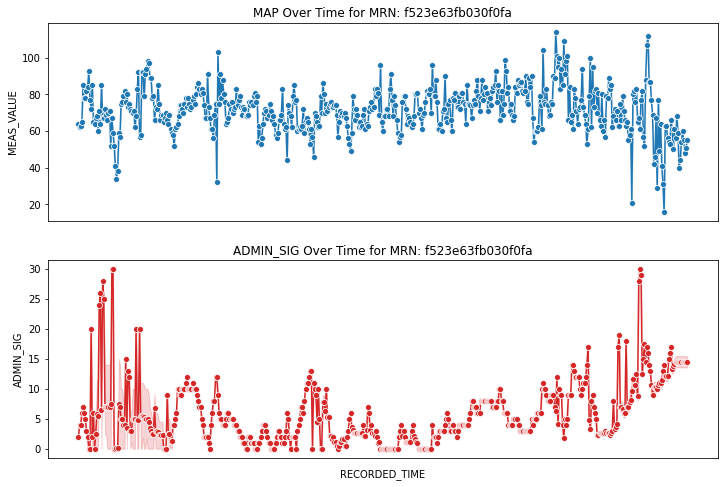

In [41]:
# Create a figure with 2 subplots (axes)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
for mrn, patient_df in merged_df_selected.groupby('MRN'):
    # Plot the MAP (MEAS_VALUE) over time
    sns.lineplot(ax=axes[0], data=patient_df , x='RECORDED_TIME', y='MEAS_VALUE', marker='o')
    axes[0].set(xticklabels=[])
    axes[0].tick_params(bottom=False)
    axes[0].set_title(f'MAP Over Time for MRN: {mrn}')

    # Plot the ADMIN_SIG over time
    sns.lineplot(ax=axes[1], data=patient_df , x='RECORDED_TIME', y='ADMIN_SIG', marker='o', color='tab:red')
    axes[1].set(xticklabels=[])
    axes[1].tick_params(bottom=False)
    axes[1].set_title(f'ADMIN_SIG Over Time for MRN: {mrn}')

    # Show the plot for this patient
    plt.show()